In [81]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from selectinf.Simulation.spline import cubic_spline, b_spline
from selectinf.Simulation.H1.nonlinear_H1_helpers import *
from selectinf.RealDataHelpers.rdhelpers import *
from sklearn.decomposition import PCA

In [82]:
fpw = pd.read_csv("fpw.csv", index_col=0)

In [83]:
fpw

,day,dep_delay,distance,plane_age,seats,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,sched_dep_hour,sched_arr_hour
0,1,28.0,187,18.0,20,42.0,30.0,62.18,360.0,9.20624,10.594357,0.00,1017.8,10.00,23,0
1,1,-12.0,1576,21.0,200,42.0,30.0,62.18,360.0,9.20624,10.594357,0.00,1017.8,10.00,23,4
2,1,6.0,1041,18.0,20,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8,11
3,1,-7.0,1182,24.0,145,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8,10
4,1,-4.0,1029,22.0,145,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435,27,-3.0,187,11.0,200,42.0,41.0,96.21,0.0,0.00000,0.000000,0.00,1019.2,1.50,5,6
8436,27,2.0,1089,1.0,185,42.0,41.0,96.21,0.0,0.00000,0.000000,0.00,1019.2,1.50,5,8
8437,16,240.0,1089,7.0,189,26.0,23.0,88.23,330.0,4.60312,5.297178,0.01,1020.9,1.25,5,8
8438,27,-5.0,209,17.0,95,42.0,39.0,89.01,160.0,4.60312,5.297178,0.00,1023.2,10.00,23,0


In [84]:
fpw["precip"].unique()

array([0.    , 0.01  , 0.02  , 0.03  , 0.0001, 0.04  ])

In [85]:
Y = fpw["dep_delay"]
X = fpw.drop(["dep_delay", 'day', "wind_gust"], axis=1)

In [165]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.9,
                                                    random_state=42)
# Standardize
#x_train = (x_train - x_train.mean()) / x_train.std()
#x_test = (x_test - x_train.mean()) / x_train.std()

# Construct splines

In [166]:
def get_splines(x_nl, x_l, nknots, degree, intercept):
    bs = b_spline(data_nl=np.array(x_nl), data_l=np.array(x_l), 
                  nknots=nknots, degree=degree, intercept=intercept)
    bs.construct_splines(use_quantiles=True, equally_spaced=False, center=False)
    design_train = bs.get_spline_data()
    design_train *= np.sqrt(design_train.shape[0])
    design_train[:, 0] = 1
    # Returning group labels with 0 meaning the intercept (if applicable)
    groups = bs.get_groups()

    return design_train, groups


In [167]:
linear = list(x_train.columns[x_train.nunique() < 40])

In [168]:
x_train.nunique()

distance           59
plane_age          31
seats              26
temp               41
dewp               52
humid             230
wind_dir           36
wind_speed         21
precip              6
pressure          217
visib              19
sched_dep_hour     18
sched_arr_hour     21
dtype: int64

In [172]:
x_train_nl = x_train.drop(linear, axis=1)
x_train_l_temp = x_train[linear]
x_test_nl = x_test.drop(linear, axis=1)
x_test_l = x_test[linear]
n_train = x_train_l_temp.shape[0]
n_test = x_test_l.shape[0]

x_train_l = (x_train_l_temp - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_train))
x_test_l = (x_test_l - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_test))

In [173]:
x_test_l.std()

plane_age         0.012439
seats             0.012695
wind_dir          0.012015
wind_speed        0.012213
precip            0.011678
visib             0.012367
sched_dep_hour    0.012716
sched_arr_hour    0.012545
dtype: float64

In [174]:
x_train_l.std()

plane_age         0.036886
seats             0.036886
wind_dir          0.036886
wind_speed        0.036886
precip            0.036886
visib             0.036886
sched_dep_hour    0.036886
sched_arr_hour    0.036886
dtype: float64

In [175]:
design_train, groups_train = (
        get_splines(x_train_nl, x_train_l, nknots=6, degree=2, intercept=True))
design_test, groups_test = (
        get_splines(x_test_nl, x_test_l, nknots=6, degree=2, intercept=True))

Equally spaced quantile knots used.
Equally spaced quantile knots used.


In [176]:
# Steps:
# 1. Transform training fully for naive and MLE
# 2. Transform 90% of training for data splitting's selection
# 3. Use 10% of remaining to get the transformed PCs for data splitting's inference
# 4. 

In [177]:
design_train

array([[ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.31064035,  0.48803806],
       [ 1.        , -1.19756794, -0.48768174, ...,  0.49814698,
         0.5246241 ,  0.86247227],
       [ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.73860785,  0.86247227],
       ...,
       [ 1.        , -0.12116343,  1.10133351, ..., -1.32841514,
         0.0966566 ,  0.30082095],
       [ 1.        , -1.51037039, -0.5800947 , ..., -0.23247787,
         0.31064035,  0.67525517],
       [ 1.        , -0.22672314,  1.29537708, ...,  0.49814698,
        -0.75927839, -0.63526457]])

In [178]:
design_train.T @ design_train

array([[ 7.35000000e+02, -3.67100058e+02,  4.59106234e+02,
        -4.33438163e+02, -7.45968241e+01, -4.59180683e+02,
        -1.26910180e+02, -5.45186805e+02, -2.82949388e+02,
        -3.33743647e+02,  1.22029202e+02, -4.39648318e-14,
         8.88178420e-16,  7.46069873e-14,  2.30926389e-14,
         7.99360578e-15,  3.55271368e-15,  8.34887715e-14,
        -2.13162821e-14],
       [-3.67100058e+02,  7.35000000e+02,  2.04281037e-14,
         2.80018211e+02,  2.37180387e+01,  2.73259862e+02,
         7.53470033e+01,  2.84940969e+02,  1.49968697e+02,
         1.55389995e+02, -6.42800149e+01,  1.61092469e+01,
        -2.55856216e+02, -9.41992913e+00,  1.66531060e+01,
        -1.37017392e+01,  1.08940864e+01, -5.32271236e+00,
        -2.23713029e+01],
       [ 4.59106234e+02,  2.04281037e-14,  7.35000000e+02,
        -2.48589798e+02, -7.28982263e+01, -2.58679981e+02,
        -1.07045308e+02, -3.22637687e+02, -1.94284345e+02,
        -2.40647586e+02,  3.92143608e+01,  9.96624583e+01,
    

In [179]:
design_train

array([[ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.31064035,  0.48803806],
       [ 1.        , -1.19756794, -0.48768174, ...,  0.49814698,
         0.5246241 ,  0.86247227],
       [ 1.        , -1.29469158, -0.51859089, ...,  0.49814698,
         0.73860785,  0.86247227],
       ...,
       [ 1.        , -0.12116343,  1.10133351, ..., -1.32841514,
         0.0966566 ,  0.30082095],
       [ 1.        , -1.51037039, -0.5800947 , ..., -0.23247787,
         0.31064035,  0.67525517],
       [ 1.        , -0.22672314,  1.29537708, ...,  0.49814698,
        -0.75927839, -0.63526457]])

In [180]:
design_train.std(axis=0)

array([0.        , 0.86633933, 0.78091738, 0.80761377, 0.99483633,
       0.78083635, 0.98498027, 0.67067564, 0.92293111, 0.89096449,
       0.98612135, 0.9993195 , 0.9993195 , 0.9993195 , 0.9993195 ,
       0.9993195 , 0.9993195 , 0.9993195 , 0.9993195 ])

In [181]:
design_test.std(axis=0)

array([0.        , 0.87850686, 0.78465437, 0.79840987, 0.99396775,
       0.77836609, 0.98646269, 0.67557672, 0.92621893, 0.88931565,
       0.98917161, 1.01222734, 1.03310309, 0.97769863, 0.99383786,
       0.95030807, 1.00635762, 1.0347683 , 1.02083753])

In [182]:
const = group_lasso.gaussian
result_naive, nonzero_naive, selected_groups_naive \
    = naive_inference_real_data(X=design_train, Y=np.array(y_train), 
                                raw_data=np.array(x_train), 
                                groups=groups_train, const=const,
                                n_features=x_train.shape[1], 
                                intercept=True, weight_frac=1, level=0.9,
                                mode="weakhierarchy", root_n_scaled=False)

Selected groups: [0, 2, 9, 12]
Naive Selected Groups: 4


In [183]:
pd.DataFrame(result_naive)[pd.DataFrame(result_naive)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
2,0,11,-0.000861,-0.000137,-0.000499,0.023273
7,1,6,-0.005334,-0.001344,-0.003339,0.005835
8,1,7,-0.104158,-0.008410,-0.056284,0.052834
11,1,10,-0.152540,-0.028584,-0.090562,0.016105
15,2,11,-0.006735,-0.001117,-0.003926,0.021348
17,3,11,-0.474532,-0.205983,-0.340257,0.000030
23,6,11,-0.005974,-0.000410,-0.003192,0.058801
31,10,11,-0.318240,-0.083644,-0.200942,0.004782
32,11,12,-0.135980,-0.026954,-0.081467,0.013845


In [184]:
result_MLE, nonzero_MLE, selected_groups_MLE\
    = MLE_inference_real_data(X=design_train, Y=np.array(y_train), 
                              raw_data=np.array(x_train), groups=groups_train, 
                              n_features=x_train.shape[1], 
                              intercept=True, weight_frac=1, level=0.9, 
                              mode="weakhierarchy", 
                              root_n_scaled=False, proportion=0.9)

Selected groups: [0, 2, 9, 12]
MLE Selected Groups: 4


In [185]:
pd.DataFrame(result_MLE)[pd.DataFrame(result_MLE)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
2,0,11,-0.002157,-0.000039,-0.001098,0.088198
9,1,8,49.884946,410.837792,230.361369,0.035773
15,2,11,-0.019268,-0.002897,-0.011083,0.025950
16,3,8,12.151035,149.618090,80.884562,0.052912
17,3,11,-0.812186,-0.355451,-0.583819,0.000026
18,4,8,12.304301,153.753319,83.028810,0.053481
20,5,8,5.062245,65.829809,35.446027,0.054997
24,7,8,13.971674,339.208681,176.590178,0.074071
26,8,9,0.493710,6.204216,3.348963,0.053697
28,8,11,37.083561,471.560223,254.321892,0.054150


# Validate significant interactions on a holdout set

In [186]:
def validate(x_test, design_test, y_test, nonzero, selected_groups, 
             groups = None, n_features=None, intercept=True, mode="allpairs", level=0.9):
    X_E = design_test[:, nonzero]
    active_flag = np.zeros(np.unique(groups).shape[0])
    active_flag[selected_groups] = 1.
    raw_data=np.array(x_test)

    if intercept:
        active_vars_flag = active_flag[1:]
    else:
        active_vars_flag = active_flag

    data_interaction = {}
    task_idx = []
    for i in range(n_features):
        for j in range(i + 1, n_features):
            if mode == "allpairs":
                task_idx.append((i, j))
                data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]
            elif mode == 'weakhierarchy':
                if active_vars_flag[i] or active_vars_flag[j]:
                    task_idx.append((i, j))
                    data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]
            elif mode == 'stronghierarchy':
                if active_vars_flag[i] and active_vars_flag[j]:
                    task_idx.append((i, j))
                    data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]

    result_dict = interaction_t_tests_all(X_E, y_test, n_features,
                                          active_vars_flag, data_interaction,
                                          level=level, mode=mode)

    return result_dict

In [187]:
result_naive_validate = validate(x_test, design_test, y_test, nonzero_naive, 
                                 selected_groups_naive, groups = groups_train, 
                                 n_features=x_train.shape[1],
                                 intercept=True, mode="weakhierarchy", level=0.9)

In [188]:
pd.DataFrame(result_naive_validate)

,i,j,CI_l,CI_u,beta_hat,pval
0,0,1,-0.000110,0.000003,-0.000054,1.207180e-01
1,0,8,0.324674,0.613700,0.469187,9.240632e-08
2,0,11,-0.000183,-0.000023,-0.000103,3.399931e-02
3,1,2,-0.000969,-0.000045,-0.000507,7.089916e-02
4,1,3,-0.003624,0.003989,0.000183,9.370503e-01
5,1,4,0.002223,0.011406,0.006815,1.462738e-02
6,1,5,0.001430,0.005039,0.003235,3.193164e-03
7,1,6,-0.001934,-0.001039,-0.001487,4.624778e-08
8,1,7,-0.013080,0.008837,-0.002121,7.501397e-01
9,1,8,44.616513,73.456631,59.036572,1.638505e-11


In [189]:
result_MLE_validate = validate(x_test, design_test, y_test, nonzero_MLE, 
                                 selected_groups_MLE, groups = groups_train, 
                                 n_features=x_train.shape[1],
                                 intercept=True, mode="weakhierarchy", level=0.9)

In [190]:
pd.DataFrame(result_MLE_validate)

,i,j,CI_l,CI_u,beta_hat,pval
0,0,1,-0.000110,0.000003,-0.000054,1.207180e-01
1,0,8,0.324674,0.613700,0.469187,9.240632e-08
2,0,11,-0.000183,-0.000023,-0.000103,3.399931e-02
3,1,2,-0.000969,-0.000045,-0.000507,7.089916e-02
4,1,3,-0.003624,0.003989,0.000183,9.370503e-01
5,1,4,0.002223,0.011406,0.006815,1.462738e-02
6,1,5,0.001430,0.005039,0.003235,3.193164e-03
7,1,6,-0.001934,-0.001039,-0.001487,4.624778e-08
8,1,7,-0.013080,0.008837,-0.002121,7.501397e-01
9,1,8,44.616513,73.456631,59.036572,1.638505e-11


In [191]:
naive_df = pd.DataFrame(result_naive)
naive_significant = \
    [(naive_df["i"][k], naive_df["j"][k]) for k in range(naive_df.shape[0])
     if naive_df["pval"][k] < 0.1]
naive_insig = \
    [(naive_df["i"][k], naive_df["j"][k]) for k in range(naive_df.shape[0])
     if naive_df["pval"][k] >= 0.1]

In [192]:
naive_test_df = pd.DataFrame(result_naive_validate)
naive_test_significant = \
    [(naive_test_df["i"][k], naive_test_df["j"][k]) for k in range(naive_test_df.shape[0])
     if naive_test_df["pval"][k] < 0.1]
naive_test_insig = \
    [(naive_test_df["i"][k], naive_test_df["j"][k]) for k in range(naive_test_df.shape[0])
     if naive_test_df["pval"][k] >= 0.1]

In [193]:
naive_all = [(naive_test_df["i"][k], naive_test_df["j"][k]) 
             for k in range(naive_test_df.shape[0])]

In [194]:
len(set(naive_test_significant).intersection(set(naive_significant))) / len(set(naive_significant))

0.7777777777777778

In [195]:
len(set(naive_test_insig).intersection(set(naive_insig))) / len(set(naive_test_insig))

0.7142857142857143

In [196]:
MLE_df = pd.DataFrame(result_MLE)
MLE_significant = \
    [(MLE_df["i"][k], MLE_df["j"][k]) for k in range(MLE_df.shape[0])
     if MLE_df["pval"][k] < 0.1]
MLE_insig = \
    [(MLE_df["i"][k], MLE_df["j"][k]) for k in range(MLE_df.shape[0])
     if MLE_df["pval"][k] >= 0.1]

In [197]:
len(MLE_significant)

12

In [198]:
MLE_test_df = pd.DataFrame(result_MLE_validate)
MLE_test_significant = \
    [(MLE_test_df["i"][k], MLE_test_df["j"][k]) for k in range(MLE_test_df.shape[0])
     if MLE_test_df["pval"][k] < 0.1]
MLE_test_insig = \
    [(MLE_test_df["i"][k], MLE_test_df["j"][k]) for k in range(MLE_test_df.shape[0])
     if MLE_test_df["pval"][k] >= 0.1]

In [199]:
MLE_all = [(MLE_test_df["i"][k], MLE_test_df["j"][k]) 
             for k in range(MLE_test_df.shape[0])]

In [200]:
alpha = 0.1
naive_train = [(naive_df["pval"][k] < alpha) for k in range(naive_df.shape[0])]
naive_test = [(naive_test_df["pval"][k] < alpha) for k in range(naive_test_df.shape[0])]

In [201]:
from sklearn.metrics import confusion_matrix
# tn, fp, 
# fn, tp
confusion_matrix(naive_test, naive_train)

array([[ 5,  2],
       [19,  7]])

In [202]:
from sklearn.metrics import f1_score
f1_score(naive_test, naive_train)

0.4

In [203]:
MLE_train = [(MLE_df["pval"][k] < alpha) for k in range(MLE_df.shape[0])]
MLE_test = [(MLE_test_df["pval"][k] < alpha) for k in range(MLE_test_df.shape[0])]

In [204]:
from sklearn.metrics import confusion_matrix
# tn, fp, 
# fn, tp
confusion_matrix(MLE_test, MLE_train)

array([[ 7,  0],
       [14, 12]])

In [205]:
from sklearn.metrics import f1_score
f1_score(MLE_test, MLE_train)

0.631578947368421

In [206]:
len(set(MLE_test_significant).intersection(set(MLE_significant)))# / len(MLE_test_significant)

12

In [437]:
len(set(MLE_test_insig).intersection(set(MLE_insig)))# / len(set(MLE_test_insig))

15

# Repeated subsampling

In [222]:
def subsampling_inference(Y, X, test_size, n_rep, alpha = 0.1):
    f1_dict = {"method":[], "F1":[]}
    
    for i in range(n_rep):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=test_size,
                                                            random_state=i)
    
        linear = list(x_train.columns[x_train.nunique() < 40])
        x_train_nl = x_train.drop(linear, axis=1)
        x_train_l_temp = x_train[linear]
        x_test_nl = x_test.drop(linear, axis=1)
        x_test_l = x_test[linear]
        n_train = x_train_l_temp.shape[0]
        n_test = x_test_l.shape[0]
        
        x_train_l = (x_train_l_temp - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_train))
        x_test_l = (x_test_l - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_test))
        design_train, groups_train = (
            get_splines(x_train_nl, x_train_l, nknots=6, degree=2, intercept=True))
        design_test, groups_test = (
            get_splines(x_test_nl, x_test_l, nknots=6, degree=2, intercept=True))
    
        const = group_lasso.gaussian
    
    
        result_naive, nonzero_naive, selected_groups_naive \
            = naive_inference_real_data(X=design_train, Y=np.array(y_train),
                                        raw_data=np.array(x_train),
                                        groups=groups_train, const=const,
                                        n_features=x_train.shape[1],
                                        intercept=True, weight_frac=0.75, level=0.9,
                                        mode="weakhierarchy", root_n_scaled=False)
        
        result_MLE, nonzero_MLE, selected_groups_MLE \
            = MLE_inference_real_data(X=design_train, Y=np.array(y_train),
                                      raw_data=np.array(x_train), groups=groups_train,
                                      n_features=x_train.shape[1],
                                      intercept=True, weight_frac=0.75, level=0.9,
                                      mode="weakhierarchy",
                                      root_n_scaled=False, proportion=0.9)
    
        result_naive_validate = validate(x_test, design_test, y_test, nonzero_naive,
                                         selected_groups_naive, groups=groups_train,
                                         n_features=x_train.shape[1],
                                         intercept=True, mode="weakhierarchy", level=0.9)
    
        result_MLE_validate = validate(x_test, design_test, y_test, nonzero_MLE,
                                       selected_groups_MLE, groups=groups_train,
                                       n_features=x_train.shape[1],
                                       intercept=True, mode="weakhierarchy", level=0.9)
    
        naive_df = pd.DataFrame(result_naive)
        naive_test_df = pd.DataFrame(result_naive_validate)
        MLE_df = pd.DataFrame(result_MLE)
        MLE_test_df = pd.DataFrame(result_MLE_validate)
        
        naive_train = [(naive_df["pval"][k] < alpha) for k in range(naive_df.shape[0])]
        naive_test = [(naive_test_df["pval"][k] < alpha) for k in range(naive_test_df.shape[0])]
        
        
        MLE_train = [(MLE_df["pval"][k] < alpha) for k in range(MLE_df.shape[0])]
        MLE_test = [(MLE_test_df["pval"][k] < alpha) for k in range(MLE_test_df.shape[0])]
        
        f1_dict["method"].append("Naive")
        f1_dict["F1"].append(f1_score(naive_test, naive_train))
        f1_dict["method"].append("MLE")
        f1_dict["F1"].append(f1_score(MLE_test, MLE_train))
    return f1_dict
    
    

In [224]:
f1_dict = subsampling_inference(Y, X, test_size=0.9, n_rep=30, alpha=0.1)

Equally spaced quantile knots used.
Equally spaced quantile knots used.
Selected groups: [0, 2, 3, 5, 8, 11, 12]
Naive Selected Groups: 7
Selected groups: [0, 3, 5, 8, 12]
MLE Selected Groups: 5
Equally spaced quantile knots used.
Equally spaced quantile knots used.
Selected groups: [0, 1, 2, 5, 11, 12]
Naive Selected Groups: 6
Selected groups: [0, 1, 2, 5, 12]
MLE Selected Groups: 5
Equally spaced quantile knots used.
Equally spaced quantile knots used.
Selected groups: [0, 2, 5, 9, 12]
Naive Selected Groups: 5
Selected groups: [0, 2, 5, 9, 12]
MLE Selected Groups: 5
Equally spaced quantile knots used.
Equally spaced quantile knots used.
Selected groups: [0, 5, 8, 11, 12]
Naive Selected Groups: 5
Selected groups: [0, 5, 8, 12]
MLE Selected Groups: 4
Equally spaced quantile knots used.
Equally spaced quantile knots used.
Selected groups: [0, 2, 5, 7, 8, 11, 12]
Naive Selected Groups: 7
Selected groups: [0, 2, 5, 8, 12]
MLE Selected Groups: 5
Equally spaced quantile knots used.
Equally 

TypeError: cannot unpack non-iterable NoneType object

<Axes: xlabel='method', ylabel='F1'>

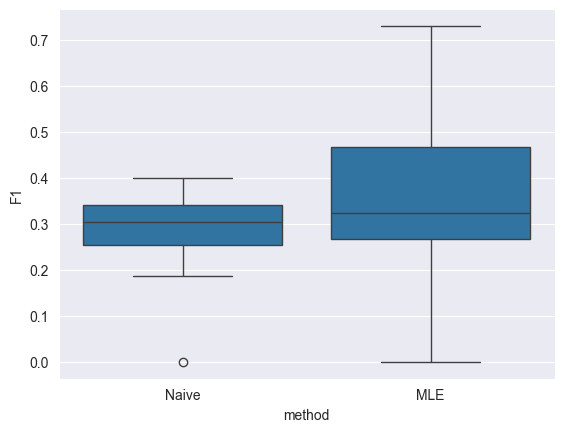

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(
    data=pd.DataFrame(f1_dict),
    x='method',
    y='F1'
)